<h1>Customer Lifetime Value With Probabilistic Model</h1>

<img src="https://mllehmdz0sx3.i.optimole.com/w:1600/h:412/q:mauto/f:best/ig:avif/https://fraudblocker.com/wp-content/uploads/2024/01/Lifetime-Value-LTV.jpg" alt="Customer Lifetime Value" width="1000" height="1000">

### Business Problem

- An online betting company would like to know each customer lifetime value for 6 months and 12 months periods.
- We will utilize one of the Buy Till You Die model BG/NBD for predicting deposit amounts and then used Gamma-Gamma model to predict Customer Lifetime Value for desired periods. 

### Importing Libraries

In [1]:
# pip install lifetimes

In [2]:
# pip install seaborn

In [3]:
import lifetimes

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler

from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Reading Data

In [4]:
query = """
select * from pokermem.tbl_transaction limit 100;
select * from pokermem.tbl_moneytype limit 100;
select distinct MTY_cDirection from pokermem.tbl_moneytype;
select MTY_cName, count(1) from pokermem.tbl_moneytype group by MTY_cName;

select
	count(1),
	avg(transaction_cnt)
from
	(
	select
		player_id,
		day_id,
		transaction_type,
		round(avg(amount), 2) as avg_amount,
		sum(amount) as tot_amount,
		count(date_id) as transaction_cnt
	from
		(
		select
			case
				when m.MTY_cDirection = 'deposit' then t.tra_ply_iID_from
				else t.tra_ply_iID_to
			end as player_id,
			date(t.TRA_dAccounting) as day_id,
			t.TRA_dAccounting as date_id,
			m.MTY_cDirection as transaction_type,
			t.TRA_iAmount as amount
		from
			pokermem.tbl_transaction t
		left join pokermem.tbl_moneytype m
on
			t.TRA_MTY_iID = m.MTY_iID
		where
			date(t.TRA_dAccounting) >= '2020-01-01'
			and t.TRA_iAmount > 0
			and (m.MTY_iID between 1000 and 1999
				and m.MTY_cDirection = 'deposit'
				or m.MTY_iID between 2000 and 2999
				and m.MTY_cDirection = 'withdraw')
) tbl
	group by
		player_id,
		day_id,
		transaction_type
	order by
		player_id,
		day_id,
		transaction_type
) tbl2
"""

"""SDG Players Only"""
"""MIR"""
# test ones select p.PLY_iHousePlayer = 4 from pokermem.player as p limit 10;
# exclude test players and house players and agent players player_type, Custodial and Non-custodial also


'MIR'

In [5]:
new_query = """
with transactions as 
(
select
		player_id,
		day_id,
		transaction_type,
		round(avg(amount), 2) as avg_amount,
		sum(amount) as tot_amount,
		count(date_id) as transaction_cnt
from
		(
	select
			case
				when m.MTY_cDirection = 'deposit' then t.tra_ply_iID_from
			else t.tra_ply_iID_to
		end as player_id,
			date(t.TRA_dAccounting) as day_id,
			t.TRA_dAccounting as date_id,
			m.MTY_cDirection as transaction_type,
			t.TRA_iAmount as amount
	from
			pokermem.tbl_transaction t
	left join pokermem.tbl_moneytype m
        on
			t.TRA_MTY_iID = m.MTY_iID
	where
			date(t.TRA_dAccounting) >= '2000-01-01'
		and t.TRA_iAmount > 0
		and (m.MTY_iID between 1000 and 1999
			and m.MTY_cDirection = 'deposit'
			or m.MTY_iID between 2000 and 2999
			and m.MTY_cDirection = 'withdraw')
) tbl
group by
		player_id,
		day_id,
		transaction_type
order by
		player_id,
		day_id,
		transaction_type
),
money_type as 
(
select
	PLY_iID,
	PLY_Currency_alpha3
from
	player
)
select
	tran.*,
	mt.PLY_iID,
	mt.PLY_Currency_alpha3,
	pt.name
from
	transactions tran
left join money_type mt
on
	tran.player_id = mt.PLY_iID
left join pokermem.player p
  on
	tran.player_id = p.PLY_iID
left join pokermem.player_type pt
  on
	p.PLY_iHousePlayer = pt.value
where
	player_id is not null
	and pt.name not in ('Houseplayer', 'Custodial', 'Non-custodial', 'Testplayer');
"""

In [6]:
# data = pd.read_csv(r"Result - 1 2025-09-09 15-20-52.csv")
data = pd.read_csv(r"Result - 1 2025-09-09 15-40-59.csv")

data = data[data["player_id"].notnull()]
data["player_id"] = data["player_id"].astype('int64')
data["day_id"] = pd.to_datetime(data["day_id"])

data.head(5)

,player_id,day_id,transaction_type,avg_amount,tot_amount,transaction_cnt,PLY_iID,PLY_Currency_alpha3,name
0,10311,2021-10-30,deposit,1000.0,1000,1,10311,SGD,Regular
1,10311,2021-11-03,deposit,1000.0,2000,2,10311,SGD,Regular
2,10311,2021-11-05,deposit,1000.0,2000,2,10311,SGD,Regular
3,10311,2021-11-06,deposit,1000.0,1000,1,10311,SGD,Regular
4,10311,2021-11-07,deposit,1000.0,1000,1,10311,SGD,Regular


In [7]:
# Singaporian Currency Only
data = data[data["PLY_Currency_alpha3"]=="SGD"]

In [8]:
data.groupby("name").avg_amount.mean().round(0)

name
Abuser               23748.0
Agentplayer          11000.0
Bronze               40067.0
Bronze Variant       56557.0
Diamond             352978.0
Diamond Variant      13461.0
Gold                105294.0
Platinum            176832.0
Platinum Variant      9167.0
Regular              25989.0
Regular Variant      19758.0
Scammer             148018.0
Silver               65062.0
Name: avg_amount, dtype: float64

In [9]:
data[data["player_id"]==223783]

,player_id,day_id,transaction_type,avg_amount,tot_amount,transaction_cnt,PLY_iID,PLY_Currency_alpha3,name


In [10]:
# from matplotlib.pyplot import figure
# figure(figsize=(8, 6), dpi=200)

# data.groupby("day_id").tot_amount.sum().plot()

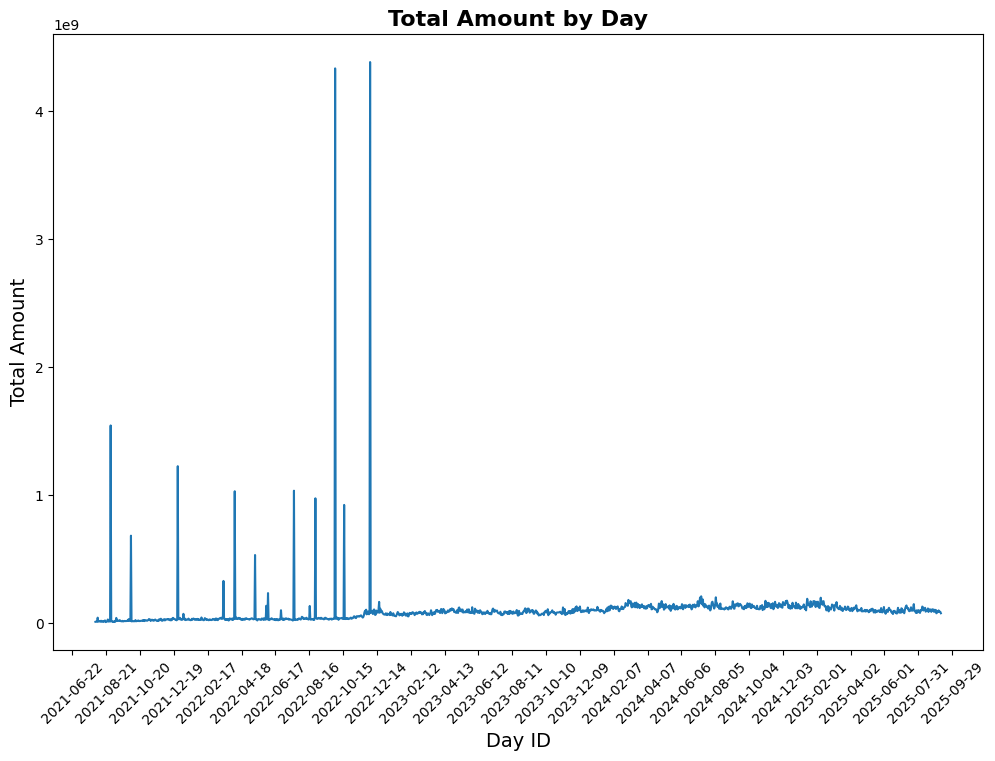

In [94]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

# Set a nice style
#sns.set_theme(style="whitegrid")

# Aggregate your data
day_totals = data.groupby("day_id")["tot_amount"].sum()[-1500:]

# Plot as a bar chart
plt.figure(figsize=(12, 8))
sns.lineplot(x=day_totals.index, y=day_totals.values)

# Titles and labels
plt.title("Total Amount by Day", fontsize=16, weight="bold")
plt.xlabel("Day ID", fontsize=14)
plt.ylabel("Total Amount", fontsize=14)

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

# Rotate x labels if necessary
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [13]:
data.groupby("day_id").tot_amount.sum().to_clipboard()

In [14]:
data.groupby("player_id").agg({"tot_amount": 'sum', "day_id":'count'}).reset_index().sort_values(by="tot_amount", ascending = False).head(50)

,player_id,tot_amount,day_id
6059,18195,4546304908,2044
4017,11519,4313235279,479
2945,7739,1529486600,1
90,306,1259971100,221
4803,14214,1028961414,587
565,2288,1016194969,506
8351,27483,1010266100,20
6506,19898,978462244,1817
199,452,911079272,493
1050,3412,884709326,81


In [15]:
data.shape

(2519505, 9)

In [16]:
data["transaction_type"].value_counts()
data.groupby("transaction_type").tot_amount.sum()

transaction_type
deposit     143429232664
withdraw     81543929136
Name: tot_amount, dtype: int64

In [17]:
dd = data.pivot_table(index = "day_id", columns="transaction_type", values="tot_amount", aggfunc="sum")
dd["wdr_rate"] = dd["withdraw"]/dd["deposit"]
dd.wdr_rate.mean()

np.float64(0.6724541945230061)

In [18]:
370861448790/110366387451000

0.0033602753279811165

In [19]:
# Deposits only
data = data[data["transaction_type"]=="deposit"]

In [20]:
# bm["msisdn_1"] = bm["bundle_msisdn"]
data["player_id_1"] = data["player_id"]

In [21]:
data = data[["player_id", "day_id", "player_id_1", "tot_amount"]]
data.sample(3)

,player_id,day_id,player_id_1,tot_amount
163351,158204,2025-07-14,158204,20000
2124571,6410,2022-02-15,6410,18000
1637749,5984,2025-03-18,5984,50000


In [22]:
# bm.columns = ["msisdn", "day_id", "msisdn_1", "bundle_fee"]

#### Preprocess the data

In [23]:
import datetime
from dateutil.relativedelta import relativedelta

In [24]:
data["day_id_new"] = data["day_id"]

In [25]:
data.day_id.isna().sum()

np.int64(0)

In [26]:
data = data[data["day_id"].notna()]

In [27]:
# data["day_id"] = data["day_id"].astype('int64')

In [28]:
# data["day_id"]

In [29]:
# data["day_id"] = data["day_id"].apply(lambda x: datetime.datetime.strptime(str(x), "%Y%m%d"))

In [30]:
None

In [31]:
data["month_id"]=data.day_id.apply(lambda x: str(x)[:7])

In [32]:
# data["msisdn_1"] = data["msisdn"]

In [33]:
data.sample(3)

,player_id,day_id,player_id_1,tot_amount,day_id_new,month_id
1895607,3811,2022-07-18,3811,2000,2022-07-18,2022-07
2455381,7827,2022-05-13,7827,50000,2022-05-13,2022-05
2191610,149148,2023-10-20,149148,2000,2023-10-20,2023-10


In [34]:
# data["quarter"] = pd.PeriodIndex(data['day_id'] ,freq='Q')
data["month"] = pd.PeriodIndex(data['day_id'] ,freq='M')

In [35]:
data["tot_amount"] = np.where(data["tot_amount"].isna(), 0, data["tot_amount"])

In [36]:
# Day
data1 = data.groupby(["player_id", "day_id"]).agg(Quantity = ("player_id_1", 'count'),
                                                  UnitPrice = ("tot_amount", 'mean'),
                                                  InvoiceDate = ("day_id", 'min')).reset_index()
data1.sample(3)

,player_id,day_id,Quantity,UnitPrice,InvoiceDate
260933,5994,2021-08-27,1,44594.0,2021-08-27
735054,30627,2022-08-07,1,7500.0,2022-08-07
1087588,155266,2024-08-18,1,1000.0,2024-08-18


In [37]:
# Quarter, Month
data1 = data.groupby(["player_id", "month_id"]).agg(Quantity = ("player_id_1", 'count'),
                                                    UnitPrice = ("tot_amount", 'mean'),
                                                    InvoiceDate = ("day_id", 'min')).reset_index()
data1.sample(3)

,player_id,month_id,Quantity,UnitPrice,InvoiceDate
103557,32430,2024-11,3,9666.666667,2024-11-16
150044,151439,2025-02,2,21600.000000,2025-02-20
73273,19897,2024-07,2,80000.000000,2024-07-08


In [38]:
data1.columns = ["CustomerID", "day_id", "Quantity", "UnitPrice", "InvoiceDate"]

In [39]:
data1.sample(5)

,CustomerID,day_id,Quantity,UnitPrice,InvoiceDate
9542,2555,2024-04,16,151293.750000,2024-04-01
118036,56543,2023-02,9,23333.333333,2023-02-01
228934,240484,2025-07,18,13616.666667,2025-07-01
111669,34313,2024-03,1,7000.000000,2024-03-19
13992,3381,2021-04,7,12714.285714,2021-04-02


#### Data Understanding

In [40]:
data1.head()

,CustomerID,day_id,Quantity,UnitPrice,InvoiceDate
0,133,2020-12,5,121900.0,2020-12-12
1,133,2021-01,4,27625.0,2021-01-03
2,133,2021-02,1,40000.0,2021-02-11
3,133,2021-03,4,36875.0,2021-03-03
4,133,2021-05,1,700000.0,2021-05-29


In [41]:
data1.shape

(298746, 5)

In [42]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298746 entries, 0 to 298745
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   CustomerID   298746 non-null  int64         
 1   day_id       298746 non-null  object        
 2   Quantity     298746 non-null  int64         
 3   UnitPrice    298746 non-null  float64       
 4   InvoiceDate  298746 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 11.4+ MB


In [43]:
data1.describe()

,CustomerID,Quantity,UnitPrice,InvoiceDate
count,298746.000000,298746.000000,2.987460e+05,298746
mean,152366.650928,6.001346,6.215255e+04,2024-01-19 12:23:43.486171904
min,133.000000,1.000000,1.000000e+01,2020-11-06 00:00:00
25%,20306.000000,1.000000,6.000000e+03,2023-04-01 00:00:00
50%,151209.000000,3.000000,1.474000e+04,2024-03-09 00:00:00
75%,232712.750000,8.000000,3.500000e+04,2024-12-07 00:00:00
max,638256.000000,31.000000,1.529487e+09,2025-09-09 00:00:00
std,140560.491765,6.720668,3.256470e+06,NaN


In [44]:
data1["UnitPrice"].min(), data1["UnitPrice"].max()

(np.float64(10.0), np.float64(1529486600.0))

In [45]:
# sns.distplot(data1.UnitPrice)

### Data Preprocessing

In [46]:
# df = df[df['Quantity'] > 0 ]
# df = df[df['UnitPrice'] > 0]
# df = df[~df['InvoiceNo'].str.contains("C",na=False)] # drop returned items

In [47]:
data1 = data1[data1['Quantity'] > 0 ]
data1 = data1[data1['UnitPrice'] > 0]
# bm1 = bm1[~bm1['InvoiceNo'].str.contains("C",na=False)] # drop returned items

#### Missing Values


In [48]:
data1.isna().sum()

CustomerID     0
day_id         0
Quantity       0
UnitPrice      0
InvoiceDate    0
dtype: int64

#### Handling Outliers

In [49]:
def find_boundaries(df, variable, q1=0.05, q2=0.95):

    # the boundaries are the quantiles

    lower_boundary = df[variable].quantile(q1)
    upper_boundary = df[variable].quantile(q2)

    return upper_boundary, lower_boundary

def capping_outliers(df,variable):
    upper_boundary, lower_boundary =  find_boundaries(df,variable)
    df[variable] = np.where(df[variable] > upper_boundary, upper_boundary,
                       np.where(df[variable] < lower_boundary, lower_boundary, df[variable]))

In [50]:
capping_outliers(data1,'UnitPrice')
capping_outliers(data1,'Quantity')

In [51]:
data1.describe()

,CustomerID,Quantity,UnitPrice,InvoiceDate
count,298746.000000,298746.000000,298746.000000,298746
mean,152366.650928,5.825755,31918.968994,2024-01-19 12:23:43.486171904
min,133.000000,1.000000,2000.000000,2020-11-06 00:00:00
25%,20306.000000,1.000000,6000.000000,2023-04-01 00:00:00
50%,151209.000000,3.000000,14740.000000,2024-03-09 00:00:00
75%,232712.750000,8.000000,35000.000000,2024-12-07 00:00:00
max,638256.000000,22.000000,171214.062500,2025-09-09 00:00:00
std,140560.491765,6.208953,43244.445698,NaN


#### Filtering only United Kingdom for Country

In [52]:
data1.head()

,CustomerID,day_id,Quantity,UnitPrice,InvoiceDate
0,133,2020-12,5.0,121900.0000,2020-12-12
1,133,2021-01,4.0,27625.0000,2021-01-03
2,133,2021-02,1.0,40000.0000,2021-02-11
3,133,2021-03,4.0,36875.0000,2021-03-03
4,133,2021-05,1.0,171214.0625,2021-05-29


In [53]:
data1.head()

,CustomerID,day_id,Quantity,UnitPrice,InvoiceDate
0,133,2020-12,5.0,121900.0000,2020-12-12
1,133,2021-01,4.0,27625.0000,2021-01-03
2,133,2021-02,1.0,40000.0000,2021-02-11
3,133,2021-03,4.0,36875.0000,2021-03-03
4,133,2021-05,1.0,171214.0625,2021-05-29


#### Creating Column 'Total Price'

In [54]:
data1['Total Price'] = data1['UnitPrice'] * data1['Quantity']

In [55]:
data1.head()

,CustomerID,day_id,Quantity,UnitPrice,InvoiceDate,Total Price
0,133,2020-12,5.0,121900.0000,2020-12-12,609500.0000
1,133,2021-01,4.0,27625.0000,2021-01-03,110500.0000
2,133,2021-02,1.0,40000.0000,2021-02-11,40000.0000
3,133,2021-03,4.0,36875.0000,2021-03-03,147500.0000
4,133,2021-05,1.0,171214.0625,2021-05-29,171214.0625


In [56]:
data1[data1["CustomerID"]==133].InvoiceDate.value_counts()

InvoiceDate
2020-12-12    1
2021-01-03    1
2021-02-11    1
2021-03-03    1
2021-05-29    1
2021-06-11    1
2021-07-06    1
2021-12-22    1
2022-01-28    1
2022-02-01    1
2022-03-01    1
2022-04-01    1
2022-05-01    1
2022-06-01    1
2022-07-06    1
2022-08-01    1
2022-09-01    1
2022-10-01    1
2022-11-01    1
2022-12-02    1
2023-01-02    1
2023-02-01    1
2023-03-04    1
2023-04-01    1
2023-05-02    1
2023-06-01    1
2023-07-01    1
2023-08-05    1
2023-09-01    1
2023-10-02    1
2023-11-09    1
2023-12-01    1
2024-01-01    1
2024-07-09    1
2024-08-01    1
2024-09-02    1
2024-10-01    1
2024-11-01    1
2024-12-01    1
2025-01-02    1
2025-02-02    1
2025-03-01    1
2025-04-01    1
2025-05-01    1
2025-07-08    1
2025-08-01    1
Name: count, dtype: int64

In [57]:
data1.CustomerID.value_counts().nlargest(50)

CustomerID
235     58
444     58
322     58
319     58
478     58
372     57
211     57
327     57
2275    56
1869    56
248     56
296     56
311     56
270     56
258     56
231     56
172     56
205     56
175     56
1831    56
447     55
2209    55
2732    55
1833    55
3124    55
2300    55
2826    55
2753    55
2660    55
2558    54
2555    54
277     54
3460    54
2576    54
194     54
2834    54
3881    54
378     54
3848    54
3658    54
392     53
3612    53
4432    53
2418    53
299     53
2313    53
4668    53
450     53
2243    53
4459    53
Name: count, dtype: int64

### Creating Summary Dataset

By using lifetimes we can also create our RFM data from the original dataset.

- **Frequency** represents the number of repeat deposits the customer has made. This means that it’s one less than the total number of deposits. This is actually slightly wrong. It’s the count of time periods the customer had a deposit in. So if using days as units, then it’s the count of days the customer had a deposit on.

- **Recency** represents the age of the customer when they made their most recent deposist. This is equal to the duration between a customer’s first deposit and their latest deposit. (Thus if they have made only 1 deposit, the recency is 0.)

- **T** represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first deposit and the end of the period under study.

- **Monetary_Value** represents the average value of a given customer’s deposists. This is equal to the sum of all a customer’s deposits divided by the total number of deposits. Note that the denominator here is different than the frequency described above.

In [58]:
# clv = lifetimes.utils.summary_data_from_transaction_data(df,'CustomerID','InvoiceDate','Total Price', observation_period_end='2011-12-09')

In [59]:
data1.InvoiceDate.min(), data1.InvoiceDate.max()

(Timestamp('2020-11-06 00:00:00'), Timestamp('2025-09-09 00:00:00'))

In [60]:
clv_data1 = lifetimes.utils.summary_data_from_transaction_data(data1, 'CustomerID','InvoiceDate','Total Price', observation_period_end=data1.InvoiceDate.max())

In [61]:
# clv = clv[clv['frequency']>1] # we want only customers shopped more than 2 times

In [62]:
clv_data1 = clv_data1[clv_data1['frequency']>1] # we want only customers shopped more than 2 times

In [63]:
clv_data1.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
133,45.0,1693.0,1732.0,1.882087e+06
141,7.0,291.0,1740.0,5.742857e+04
165,50.0,1607.0,1643.0,1.019320e+06
172,55.0,1664.0,1734.0,2.020182e+06
175,55.0,1735.0,1738.0,7.917043e+05


### BG/NBD Model for Predicting Number of Deposits

In [64]:
# bgf = BetaGeoFitter(penalizer_coef=0.001)
# bgf.fit(clv['frequency'], clv['recency'], clv['T'])

In [65]:
bgf_data1 = BetaGeoFitter(penalizer_coef=0.001)
bgf_data1.fit(clv_data1['frequency'], clv_data1['recency'], clv_data1['T'])

<lifetimes.BetaGeoFitter: fitted with 22635 subjects, a: 0.36, alpha: 187.63, b: 3.90, r: 3.12>

#### Summary of BG/NBD Model

In [66]:
# bgf.summary

In [67]:
bgf_data1.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,3.124552,0.038607,3.048881,3.200223
alpha,187.634778,2.503260,182.728388,192.541167
a,0.358207,0.006486,0.345494,0.370920
b,3.900143,0.081409,3.740582,4.059703


### Visualizing our Frequency/Recency Matrix

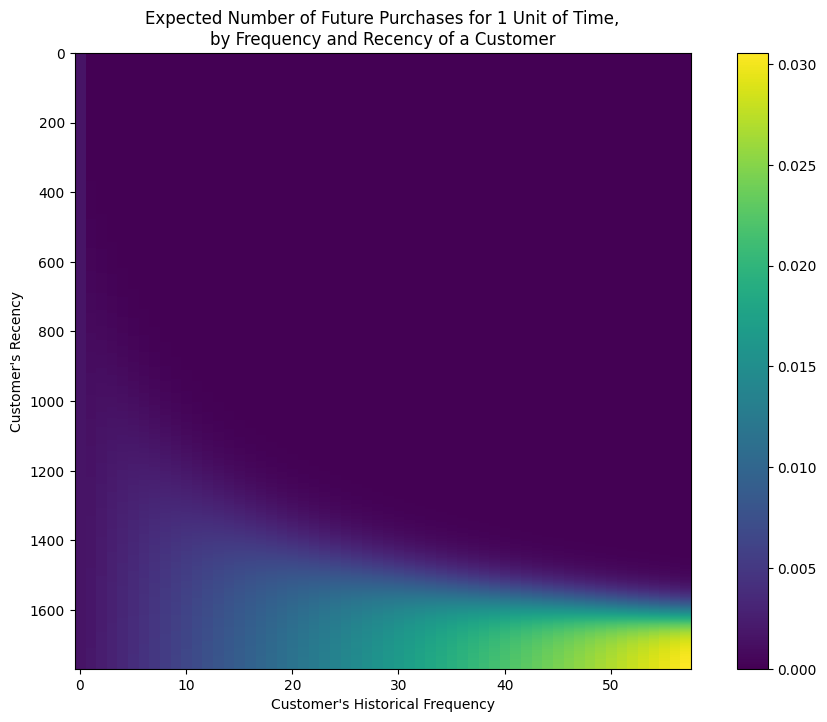

In [68]:
plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf_data1)
plt.show()

<h3>  🎯 Key Interpretations </h3>

1. <b> Bottom Right Corner (High Frequency, High Recency) — 🔥 Bright Yellow </b>

   These are customers who:

    1. Bought many times (high frequency)

    2. Made their last purchase recently (high recency)

    <b> Interpretation </b> : These are your most valuable and loyal customers — the model expects them to keep buying regularly.

    Expected purchases per unit time: ~0.025–0.030

2. <b> Top Left Corner (Low Frequency, Low Recency) — 🔮 Dark Purple </b>

    Customers with:

    1. Few or only one historical purchase

    2. Long time since their last purchase

    <b> Interpretation </b>: These are low-value, likely churned customers. Little to no expected future purchases.

4. <b> Middle Regions — Gradient </b>

    The transition from purple → blue → green → yellow shows:

    1. How expected future transactions grow as frequency increases and recency improves.

    2. This gradient reflects the model's probabilistic understanding of customer behavior.

In [69]:
# plt.figure(figsize=(8,6))
# plot_frequency_recency_matrix(bgf_bm1)
# plt.show()

#### Expected Number of Deposist in 6 Months

In [70]:
# t = 180 # 30 day period
# clv['expected_purc_6_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, clv['frequency'], clv['recency'], clv['T'])
# clv.sort_values(by='expected_purc_6_months',ascending=False).head(5)

In [71]:
t = 3 # 30 day period
clv_data1['expected_deposits_3_months'] = bgf_data1.conditional_expected_number_of_purchases_up_to_time(t, clv_data1['frequency'], clv_data1['recency'], clv_data1['T'])
clv_data1.sort_values(by='expected_deposits_3_months',ascending=False).head(5)

,frequency,recency,T,monetary_value,expected_deposits_3_months
CustomerID,,,,,
478,57.0,1712.0,1715.0,9.423713e+05,0.094156
444,57.0,1709.0,1716.0,1.162165e+06,0.094024
211,56.0,1679.0,1685.0,1.208193e+06,0.094001
2275,55.0,1647.0,1655.0,6.699467e+05,0.093858
3124,54.0,1619.0,1627.0,4.333360e+05,0.093653


In [72]:
clv_data1.reset_index().expected_deposits_3_months.min(), clv_data1.reset_index().expected_deposits_3_months.max()

(np.float64(3.781380192915868e-09), np.float64(0.09415624544139607))

#### Expected Number of Deposits ın 12 Months

In [73]:
#t = 360
#clv['expected_deposits_12_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, clv['frequency'], clv['recency'], clv['T'])
#clv.sort_values(by='expected_deposits_12_months',ascending=False).head(5)

### Gamma - Gamma Model

The Gamma-Gamma Model can predict the most likely value per transaction in the future

#### Assumption

The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel, which relies upon an important assumption. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the deposit frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [74]:
# clv[['frequency','monetary_value']].corr()

At this point we can train our Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers.

In [75]:
clv_data1[['frequency','monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.328558
monetary_value,0.328558,1.000000


In [76]:
# ggf = GammaGammaFitter(penalizer_coef=0.01)
# ggf.fit(clv["frequency"],
#         clv["monetary_value"])

In [77]:
ggf_data1 = GammaGammaFitter(penalizer_coef=0.01)
ggf_data1.fit(clv_data1["frequency"],
              clv_data1["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 22635 subjects, p: 2.40, q: 0.11, v: 2.36>

### 6 months Customer Lifetime Value

In [78]:
# clv['6_Months_CLV']=ggf.customer_lifetime_value(bgf,
#                                    clv["frequency"],
#                                    clv["recency"],
#                                    clv["T"],
#                                    clv["monetary_value"],
#                                    time=6,
#                                    freq='D',
#                                    discount_rate=0.01)

In [79]:
# clv.sort_values('6_Months_CLV',ascending=False).head()

In [80]:
clv_data1['3_Months_CLV']=ggf_data1.customer_lifetime_value(bgf_data1,
                                   clv_data1["frequency"],
                                   clv_data1["recency"],
                                   clv_data1["T"],
                                   clv_data1["monetary_value"],
                                   time=3,
                                   freq='D',
                                   discount_rate=0.01)

In [81]:
clv_data1.sort_values('3_Months_CLV',ascending=False).head()

,frequency,recency,T,monetary_value,expected_deposits_3_months,3_Months_CLV
CustomerID,,,,,,
169193,31.0,932.0,940.0,3.302256e+06,0.089537,8.684280e+06
161171,31.0,971.0,979.0,2.981927e+06,0.086554,7.583948e+06
474325,7.0,186.0,194.0,3.198037e+06,0.076067,7.278632e+06
18195,43.0,1298.0,1306.0,2.573820e+06,0.091692,6.930333e+06
30680,35.0,1044.0,1082.0,2.683137e+06,0.087414,6.889334e+06


#### Segmentation Customers by 6 Months CLV

In [82]:
# clv['Segment'] =  pd.qcut(clv['6_Months_CLV'],4,labels = ['Hibernating','Need Attention',
#                                                           'Loyal Customers','Champions'])

In [83]:
# clv.head()

In [84]:
clv_data1['Segment'] =  pd.qcut(clv_data1['3_Months_CLV'], 5, labels = ['Ready To Leave', 'Hibernating','Need Attention',
                                                                        'Loyal Customers','Champions'])

In [85]:
clv_data1.head()

,frequency,recency,T,monetary_value,expected_deposits_3_months,3_Months_CLV,Segment
CustomerID,,,,,,,
133,45.0,1693.0,1732.0,1.882087e+06,7.370781e-02,4.081203e+06,Champions
141,7.0,291.0,1740.0,5.742857e+04,3.260542e-07,5.768706e-01,Ready To Leave
165,50.0,1607.0,1643.0,1.019320e+06,8.537329e-02,2.557072e+06,Champions
172,55.0,1664.0,1734.0,2.020182e+06,8.611209e-02,5.110202e+06,Champions
175,55.0,1735.0,1738.0,7.917043e+05,8.991960e-02,2.091259e+06,Champions


In [86]:
clv_data1 = clv_data1.reset_index()
clv_data1.sample(3)

,CustomerID,frequency,recency,T,monetary_value,expected_deposits_3_months,3_Months_CLV,Segment
5929,32619,2.0,60.0,1129.0,74500.000000,0.00003,8.089885e+01,Ready To Leave
3264,16123,36.0,1328.0,1333.0,154524.777778,0.07636,3.471523e+05,Champions
4953,27439,31.0,1085.0,1123.0,843866.235920,0.07589,1.884362e+06,Champions


### Final Dataframe

In [87]:
# clv.groupby('Segment').mean()

In [88]:
clv_data1.groupby('Segment').agg({"CustomerID":'count'}).reset_index()

,Segment,CustomerID
0,Ready To Leave,4527
1,Hibernating,4527
2,Need Attention,4527
3,Loyal Customers,4527
4,Champions,4527


### Group by Segment

In [89]:
# clv.groupby('Segment').mean()

In [90]:
clv_data1.groupby('Segment').mean().round(0)

,CustomerID,frequency,recency,T,monetary_value,expected_deposits_3_months,3_Months_CLV
Segment,,,,,,,
Ready To Leave,102350.0,5.0,278.0,1087.0,95819.0,0.0,338.0
Hibernating,172622.0,5.0,527.0,864.0,65925.0,0.0,5582.0
Need Attention,200772.0,8.0,620.0,782.0,78564.0,0.0,28170.0
Loyal Customers,206180.0,13.0,693.0,782.0,153294.0,0.0,133811.0
Champions,187796.0,21.0,802.0,846.0,602107.0,0.0,1092648.0


In [91]:
clv_data1.sample()

,CustomerID,frequency,recency,T,monetary_value,expected_deposits_3_months,3_Months_CLV,Segment
6271,33748,8.0,757.0,765.0,61500.0,0.033794,63094.195413,Loyal Customers


In [96]:
clv_data1.groupby("Segment").agg({"CustomerID":'count', 
                                  "frequency":'mean',	
                                  "recency":'mean',
                                  "T":'mean',
                                  "monetary_value": 'mean',
                                  "expected_deposits_3_months":'mean',
                                  "3_Months_CLV":'mean'}).round()

,CustomerID,frequency,recency,T,monetary_value,expected_deposits_3_months,3_Months_CLV
Segment,,,,,,,
Ready To Leave,4527,5.0,278.0,1087.0,95819.0,0.0,338.0
Hibernating,4527,5.0,527.0,864.0,65925.0,0.0,5582.0
Need Attention,4527,8.0,620.0,782.0,78564.0,0.0,28170.0
Loyal Customers,4527,13.0,693.0,782.0,153294.0,0.0,133811.0
Champions,4527,21.0,802.0,846.0,602107.0,0.0,1092648.0


### Thank you

In [93]:
# Deposit - Withdrawals

# Tests

C:\Users\kuksj\AppData\Local\Programs\Python\Python313\Lib\site-packages\lifetimes\datasets\__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

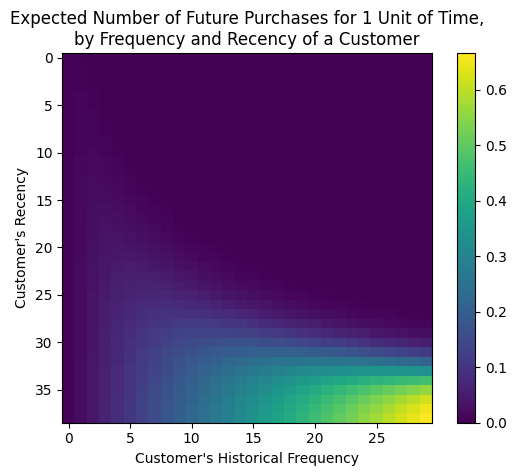

In [97]:
from lifetimes.datasets import load_cdnow_summary
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix

# Load dataset
data = load_cdnow_summary(index_col=[0])

# Fit BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])

# Plot frequency-recency matrix
plot_frequency_recency_matrix(bgf)


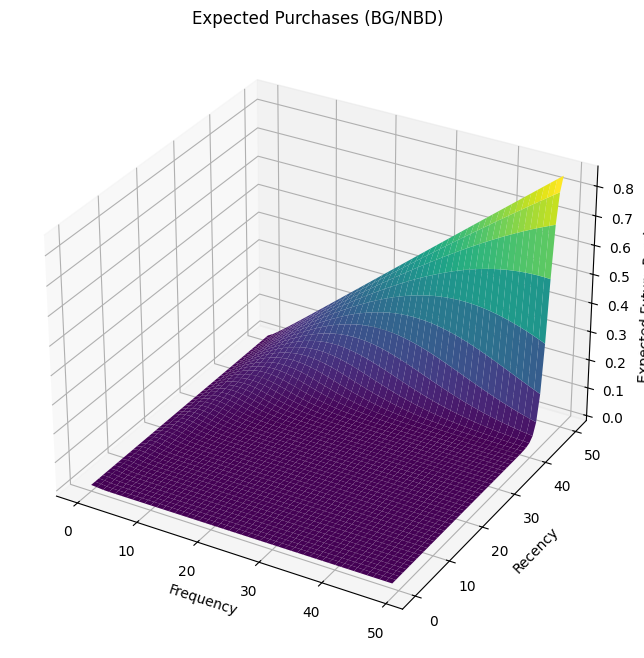

In [192]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create grid
freq = np.arange(0, 50)
rec = np.linspace(0, 50, 50)
F, R = np.meshgrid(freq, rec)

# Predict expected purchases for each (f, r) pair
Z = bgf.conditional_expected_number_of_purchases_up_to_time(1, F, R, 51)

# Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(F, R, Z, cmap='viridis')

ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
ax.set_zlabel('Expected Future Purchases')
plt.title('Expected Purchases (BG/NBD)')
plt.show()


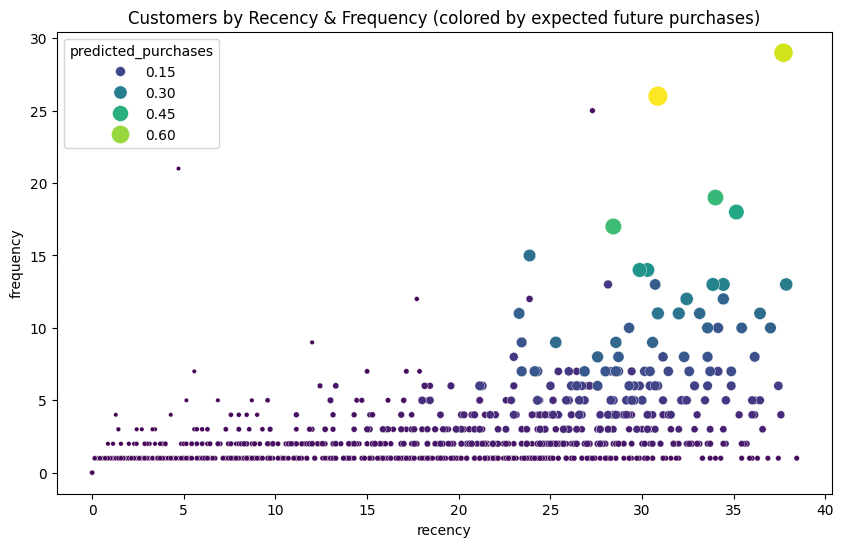

In [195]:
import seaborn as sns

data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(1, data['frequency'], data['recency'], data['T'])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='recency', y='frequency', hue='predicted_purchases', palette='viridis', size='predicted_purchases', sizes=(10, 200))
plt.title('Customers by Recency & Frequency (colored by expected future purchases)')
plt.show()

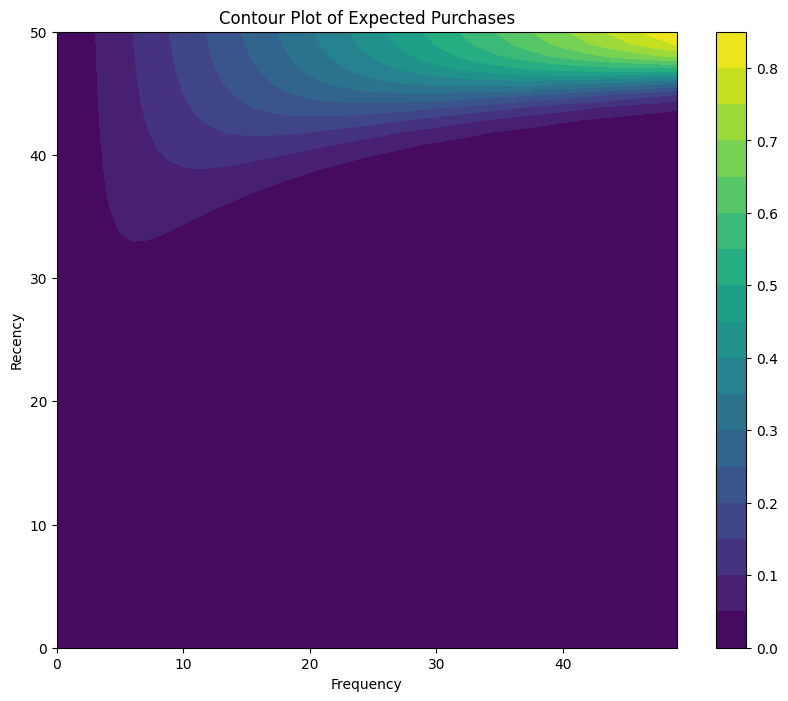

In [197]:
plt.figure(figsize=(10, 8))
cp = plt.contourf(F, R, Z, 20, cmap='viridis')
plt.xlabel("Frequency")
plt.ylabel("Recency")
plt.title("Contour Plot of Expected Purchases")
plt.colorbar(cp)
plt.show()
